# **PROJET PIZZA GANG**
*avec Alexandre Terny, Yacine El-Yamani, et Ferdinand Plesse--Costa*




Si vous ne pouvez pas entraîner les réseaux, on a enregistré les paramètres après les entraînements dans des fichiers .pth \
Vous découvrirez petit à petit en lisant, comment le projet et les dossiers du projet s'articulent.

Illustration de la synthaxe pour charger un réseau avec un fichiers .pth des paramètres :
```py
model = ModeleClass()
model.load_state_dict(torch.load('modele_run.pth'))
```

Nous avons parvenu à travailler en local et non sur google drive, c'est à dire avec nos propres GPU. Ce code permet de travailler en local en téléchargement directement la base de donnée (classe Path, download_data=True) ou non si vous l'avez déjà en local, ainsi que sur google collab en initialisant la classe avec des strings (```'gdrive'``` ou ```'local' ```).

Vous verrez cela par la suite et remarquerez aussi qu'on utilise un système de strings (```'train'```, ```'test' ```, ```'val' ``` etc) pour représenter les différents sous ensembles du dataset. Les détails vous parviendront par la suite...

Dernière remarque : les courbes et visualisations sont pour la plupart stockées dans un dossier à part. Nous vous avons envoyé ce dossier ainsi que le dossier contenant les fichiers .pth des modèles, au cas où.

On espère que vous pourrez utilisez notre code sans encombre.

*ps : on a dû utilisé num_workers=0 car sinon le programme faisait planter le kernel python lors de l'utilisation de ``iter()`` sur un objet ``torch.utils.data.DataLoader`` ...*

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Flag_of_Armenia_%281918%E2%80%931922%29.svg/220px-Flag_of_Armenia_%281918%E2%80%931922%29.svg.png" alt="1" width="5%">

### *Several code snippets for the pizza project*

*The data can be downloaded from the page: http://pizzagan.csail.mit.edu/*

*There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.*



### Calcul sur GPU google colab ou GPU local :

*sur Google Colab :*
*Runtime -> Change Runtime Type -> GPU*

Pour travailler sur son propre GPU NVIDIA, avec VS Code (notre cas) :
1) mettre à jour son pilote via GeForce Experience
2) avoir VS Code
3) installer la dernière version de CUDA Toolkit https://developer.nvidia.com/cuda-toolkit-archive
4) sur https://pytorch.org/get-started/locally/ trouver la commande pour charger torch en gpu, par exemple pour nous, sur windows avec la dernière version de CUDA toolkit on utilise : !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 

In [1]:
!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 
# changer la ligne ci dessus, cf étape 4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


### Useful libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, f1_score, precision_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

import inspect  # debugage
import platform
print(f"Python version: {platform.python_version()}")

C:\Users\ferdi\AppData\Local\Temp\ipykernel_53160\4056112828.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Sun Mar 17 14:19:08 2024       Python version: 3.12.2

+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P5              9W /   20W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

In [3]:
if not os.path.exists('./models'):
    os.makedirs('./models')

if not os.path.exists('./figures'):
    os.makedirs('./figures')

# **Managing data**

### Put the data in your directory

The following class is used to keep the paths of the database in memory.
It needs to specify whether the database is on your **google drive** or if you are working on **local**.

The second argument is if you need to download the database or if you already have it.

In [4]:
class Paths:
    def __init__(self, type, download_data=False):
        if type.lower() == 'gdrive':
            from google.colab import drive
            drive.mount('/content/gdrive/')
            self.DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'
            if download_data:
                self._download_gdrive()
        elif type.lower() == 'local':
            self.DATA_DIR = ''
            if download_data:
                self._download_local()  
        else:
            print("> argument 'type' invalide, choisir parmi 'gdrive' ou 'local'")
        self._create_all_paths()
        
    def _download_gdrive(self):
        print('> téléchargement des data sur gdrive')
        !wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
        !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'
    def _download_local(self):
        import requests
        import zipfile
        if os.path.exists('syntheticDataset'):
            print('> data déjà téléchargées')
        else:
            print('> téléchargement des data en local')
            response = requests.get('http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip')
            with open('pizzaGANsyntheticdata.zip', 'wb') as f:
                f.write(response.content)
            print('> décompression du zip')
            with zipfile.ZipFile('pizzaGANsyntheticdata.zip', 'r') as zip_ref:
                zip_ref.extractall(os.getcwd())
                
    def _create_all_paths(self):
        # deux attributs utiles : les paths des dossiers des différents set du dataset
        self.train_data = os.path.join(self.DATA_DIR, 'syntheticDataset/train')
        self.test_data = os.path.join(self.DATA_DIR, 'syntheticDataset/test')
        # deux autres attributs : emplacements de dossier pour les résultats :
        self.figures_path = os.path.join(self.DATA_DIR, 'figures')
        self.models_path = os.path.join(self.DATA_DIR, 'models')
        if not os.path.exists(self.figures_path):
            os.makedirs(self.figures_path)
            print(f"création de {self.figures_path}")
        if not os.path.exists(self.models_path):
            os.makedirs(self.models_path)
            print(f"création de {self.models_path}")

On créé aussi deux nouveaux dossiers ('figures' et 'models') pour les résultats.
Un dossier où sera enregistré les paramètres des modèles (fichiers .pth) et un dossier pour les figures (fichiers .png). \
*par exemple on pourra ainsi après un entraînement garder les figures des courbes de loss ainsi que la visualisation de la prédiction sur un batch (et la ground truth correspondante) ET un fichier .pth des paramètres finaux du modèle entraîné* 

In [5]:
paths = Paths('local', download_data=False)

### Organize the data into sets

Now we will use the two folders of the database : *train* & *test* ; \
in order to have a training set and a validation set (both from the *train* folder) and a test set (from the *test* folder)

train : to train the model with \
val : to evaluate the model during optimization \
test : to test the model on unseen data 

We will also create huge tensors made of all the images of each sets and stock it outside the code (.npz files).


##### *train* folder :

In [6]:

# 1) LOAD THE (ALL-)TRAINING SET : x_all (images index) and y_all (labels one hot encoded)
y_all = np.loadtxt(os.path.join(paths.train_data, 'trainLabels.txt'))
x_all = np.arange(y_all.shape[0])
print('> step 1:', y_all.shape, x_all.shape)
# y_all and x_all only contain image number (not the raw data)
# 2) FROM THE INDEX (x_all) CREATE A TENSOR OF THE IMAGES :
# ici on crée ce tensor dans un .npz file pour gagner du temps d'apprentissage
if (os.path.exists(os.path.join(paths.train_data, 'img_data_224.npz'))): # lecture du .npz
    img_data_tensor = np.load(os.path.join(paths.train_data, 'img_data_224.npz'))
    img_all = img_data_tensor['img_data']
    del img_data_tensor
else: # création du .npz
    img_all = []
    for idx in tqdm(x_all):
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(paths.train_data, 'images', img_name))
        img_all.append(np.array(x.resize((224,224))))
    np.savez_compressed(os.path.join(paths.train_data,'img_data_224.npz'), img_data=np.array(img_all)) 
print('> step 2:', img_all.shape)
# 3) SPLIT THE ALL-TRAINING SET INTO TRAINING AND VALIDATION SETS :
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)
print('> step 3:', y_train.shape, x_train.shape, y_val.shape, x_val.shape,)
# on utilisera x_train et x_val pour aller piocher les images dans img_all

> step 1: (4971, 10) (4971,)


> step 2: (4971, 224, 224, 3)
> step 3: (3976, 10) (3976,) (995, 10) (995,)


##### *test* folder :

In [7]:
# 1) LOAD THE TEST SET : x (image index) and y (label one hot encoded)
y_test = np.loadtxt(os.path.join(paths.test_data, 'testLabels.txt'))
x_test = np.arange(y_test.shape[0])
print('> step 1:', y_test.shape, x_test.shape)
# y_test and x_test only contain image number (not the raw data)
# 2) FROM THE INDEX (x) CREATE A TENSOR OF THE IMAGES :
# ici on crée ce tensor dans un .npz file pour gagner du temps d'apprentissage
if (os.path.exists(os.path.join(paths.test_data, 'img_data_test_224.npz'))): # lecture du .npz
    img_data_tensor = np.load(os.path.join(paths.test_data, 'img_data_test_224.npz'))
    img_test = img_data_tensor['img_data']
    del img_data_tensor
else: # création du .npz
    img_test = []
    for idx in tqdm(x_test):
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(paths.test_data, 'images', img_name))
        img_test.append(np.array(x.resize((224,224))))
    np.savez_compressed(os.path.join(paths.test_data,'img_data_test_224.npz'), img_data=np.array(img_test))
print('> step 2:', img_test.shape)
  

> step 1: (497, 10) (497,)
> step 2: (497, 224, 224, 3)


### Dataset class

Ici on a besoin d'écrire un objet pytorch (torch.utils.data.Dataset) pour :
1) récupérer les images à partir des indices contenus dans x_train/val/test
2) être compatible avec d'autres objets pytorch (les torch.utils.data.DataLoader)
3) parcourir un set du dataset avec une boucle for

In [8]:
class myDataset(torch.utils.data.Dataset):
    """Pizza dataset"""
    def __init__(self, x_idx, y, img_path=None, img_data = None, transform=None):
      self.x_idx = x_idx # x_train/val/test
      self.y = y # y_train/val/test
      self.img_path = img_path # avec la classe Path
      self.transform = transform # normalisation du set du dataset
      self.img_data = img_data # tenseur des images du set du dataset

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))

### Data loaders

La classe suivante permet de créer un dataloader pour un set du dataset ('train'/'val'/'test') en choisissant la taille des batch. \
Elle sert aussi à la visualisation des données, à la fois des images du batch et aussi des labels. \
Enfin, elle peut aussi afficher la distribution du set du dataset.

Attention à ne pas confondre notre classe *DataLoader* avec *DataLoader* de torch (*torch.utils.data.DataLoader*)

In [9]:
class DataLoader:

    def __init__(self, which_set, batch_size, input_size = 224):
        self.which_set = which_set.lower() # train/val/test
        self.batch_size = batch_size
        self.input_size = input_size
        self.kwargs = {'num_workers': 0, 'pin_memory': True} if torch.cuda.is_available() else {}
        # num_workers > 0 fait crasher le kernel python..
        self._create_normalization_transforms()
        self._which_set_of_dataset()
        self._create_dataloader()
        self.classes = ('pepperoni', 'champignons', 'poivrons', 'olives', 'roquettes', 
                        'jambon', 'brocolis', 'ananas', 'tomates', 'oignons')
                        # roquette désigne des feuilles (basilic ?)
                        # jambon on dirait du lard
                        # brocolis dans une pizza ??? c'est pire que ananas..
    def _which_set_of_dataset(self):
        if self.which_set=='train':
            self.img_path = os.path.join(paths.train_data, 'images')
            self.transform = self.train_transform
            self.x = x_train
            self.y = y_train
            self.img_data = img_all[x_train,:,:,:]
            self.do_shuffle = True
        elif self.which_set=='val':
            self.img_path = os.path.join(paths.train_data, 'images')
            self.transform = self.val_transform
            self.x = x_val
            self.y = y_val
            self.img_data = img_all[x_val,:,:,:]
            self.do_shuffle = False
        elif self.which_set==('test'):
            self.img_path = os.path.join(paths.test_data, 'images')
            self.transform = self.val_transform
            self.x = x_test
            self.y = y_test
            self.img_data = img_test[x_test,:,:,:]
            self.do_shuffle = False
        elif self.which_set==('all'): # entrainement sur 100% des données de train (0% en validation set)
            self.img_path = os.path.join(paths.train_data, 'images')
            self.transform = self.val_transform
            self.x = x_all
            self.y = y_all
            self.img_data = img_all[x_all,:,:,:]
            self.do_shuffle = False

    def _create_normalization_transforms(self):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalisation RVB
        self.train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                   transforms.RandomVerticalFlip(),
                                                   transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                                   transforms.Resize(self.input_size),
                                                   transforms.ToTensor(),
                                                   normalize])
        self.val_transform = transforms.Compose([transforms.Resize(self.input_size),
                                                 transforms.ToTensor(),
                                                 normalize])
    def _create_dataloader(self):
        self.raw_set = myDataset(self.x, self.y, 
                                img_path=self.img_path, img_data=self.img_data, 
                                transform = self.transform)
        self.dataloader = torch.utils.data.DataLoader(self.raw_set, batch_size=self.batch_size, 
                                                    shuffle=self.do_shuffle, **self.kwargs)
    
    def show_class_distribution(self):
        if self.which_set=='train':
            set_name = "d'entraînement"
        elif self.which_set=='val':
            set_name = "de validation"
        elif self.which_set=='test':
            set_name = "de test"
        class_counts = np.zeros(len(self.classes))
        for _, label in self.raw_set:
            class_counts += label
        fig, ax = plt.subplots(figsize=(6,6))
        ax.barh(self.classes, class_counts)
        ax.set_ylabel('Classes')
        ax.set_xlabel("Nombre d\'images avec l'étiquette de la classe")
        ax.set_title(f'Distribution des étiquettes dans l\'ensemble {set_name}')
        plt.show()
        
    def get_one_batch(self):
        dataiter = iter(self.dataloader)
        images, labels = next(dataiter)
        return images, labels
    
    def show_one_batch(self):
        images, labels = self.get_one_batch()
        print(f"batch_size = {images.shape[0]} et dimension d'une image = {images.shape[1:]}")
        # creation grille images :
        self._imshow(torchvision.utils.make_grid(images))
        # dimensions de la grille :
        xlim = self._fig.get_axes()[0].get_xlim()
        ylim = self._fig.get_axes()[0].get_ylim()
        self.NX = int(np.abs( xlim[1] - xlim[0] ) / self.input_size)
        self.NY = int(np.abs( ylim[1] - ylim[0] ) / self.input_size)
        # changement graduations :
        self._set_im_axis()
        # show images :
        self._fig.show()
        # show labels :
        self._show_labels_as_grid(labels)

    def _imshow(self, img):
        npimg = img.numpy()
        self._fig = plt.figure(figsize=(12,12)) # taille max possible, puis matplotlib s'adapte autour
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.grid(False)
        plt.tight_layout()
        
    def _set_im_axis(self):
        ax = self._fig.get_axes()[0]
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start+self.input_size/2 , end-self.input_size/2, self.input_size))
        ax.set_xticklabels(np.arange(self.NX))
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start-self.input_size/2 , end+self.input_size/2, -self.input_size))
        ax.set_yticklabels(np.arange(self.NY)[::-1])
        
    def _show_labels_as_grid(self, labels):
        class_names = np.array(self.classes)
        labels_name = [class_names[label==1] for label in labels]
        labels_table =  np.full((self.NY, self.NX), None)
        try:
            for ny in range(self.NY):
                for nx in range(self.NX):
                    labels_table[ny, nx] = '\n'.join(labels_name[ny*self.NX + nx])
        except IndexError:
            pass
        df = pd.DataFrame(labels_table)
        plt.figure(figsize=(self.NX, self.NY))
        sns.heatmap(df.isnull(), cmap='binary', cbar=False, annot=df.values, fmt='',
                    annot_kws={'size': 8}, linewidths=1, linecolor='black')
        plt.title('étiquettes des images du batch (multi-labels)')
        plt.show()

 ### Distributions des labels pour chaque dataset

 On a juste à préciser quel set du dataset on veut (*which_set ?* 'train'/'val'/'test' et même 'all'='train'+'val') ainsi que la taille du batch du data loader, et les méthodes de la classe permettent de pouvoir faire les visualisations du set comme on le souhaite (et dans l'avenir il est toujours possible de créer des nouvelles méthodes si on veut des nouvelles façons de visualiser le set).

In [10]:
train25 = DataLoader('train', 25)
val25 = DataLoader('val', 25)
test25 = DataLoader('test', 25)

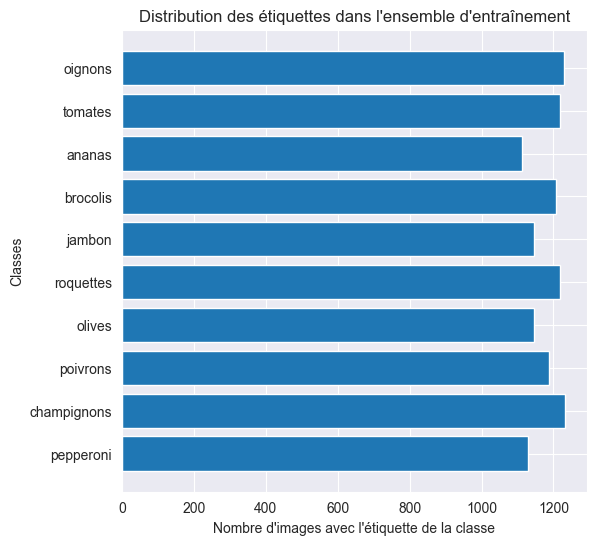

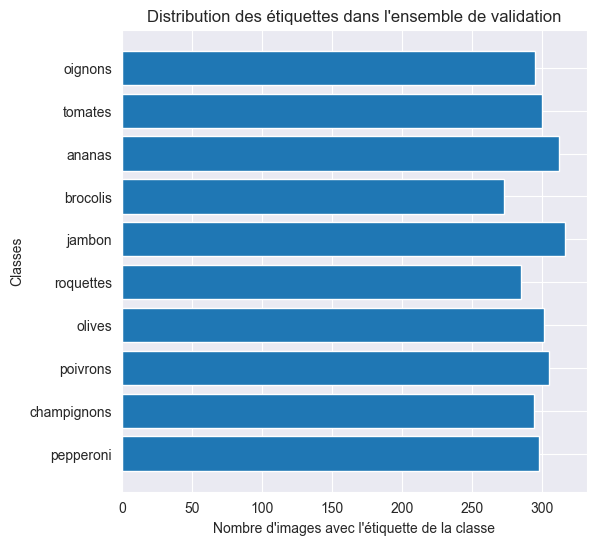

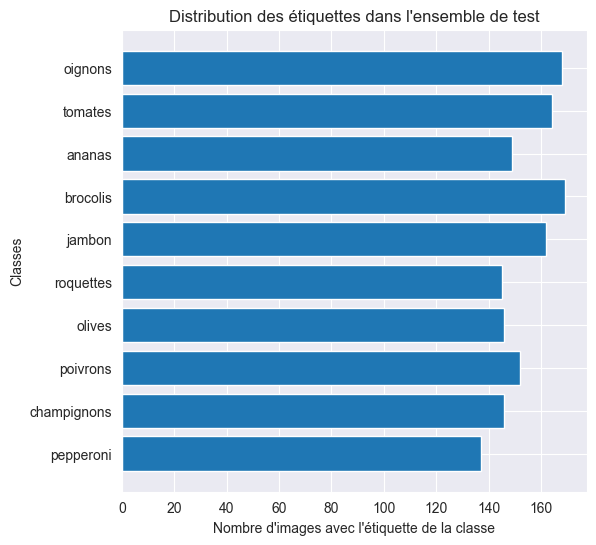

In [11]:
train25.show_class_distribution()
val25.show_class_distribution()
test25.show_class_distribution()

### Visualisation des données

Avec différentes tailles de ~~baignoires~~ bains.

TAILLE DU BAIN : 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_size = 10 et dimension d'une image = torch.Size([3, 224, 224])


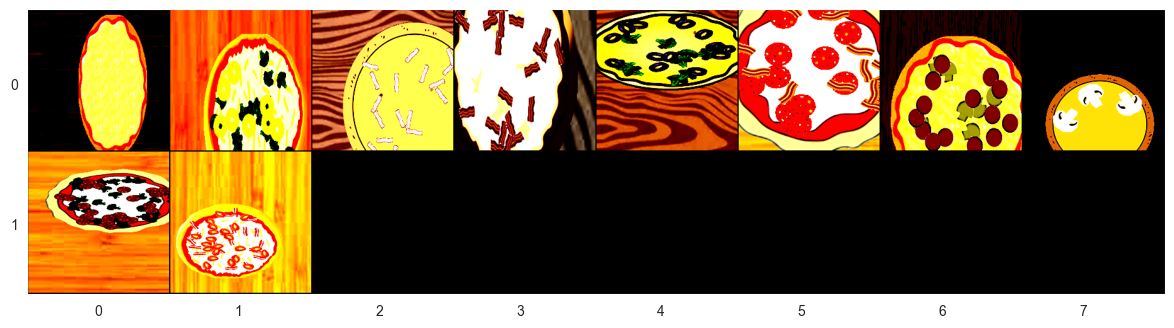

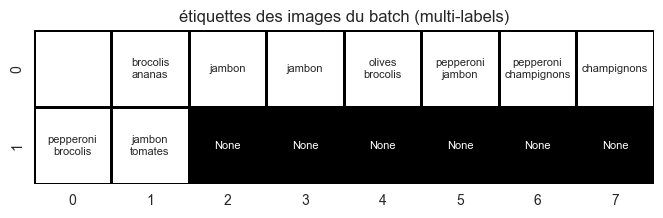

TAILLE DU BAIN : 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_size = 25 et dimension d'une image = torch.Size([3, 224, 224])


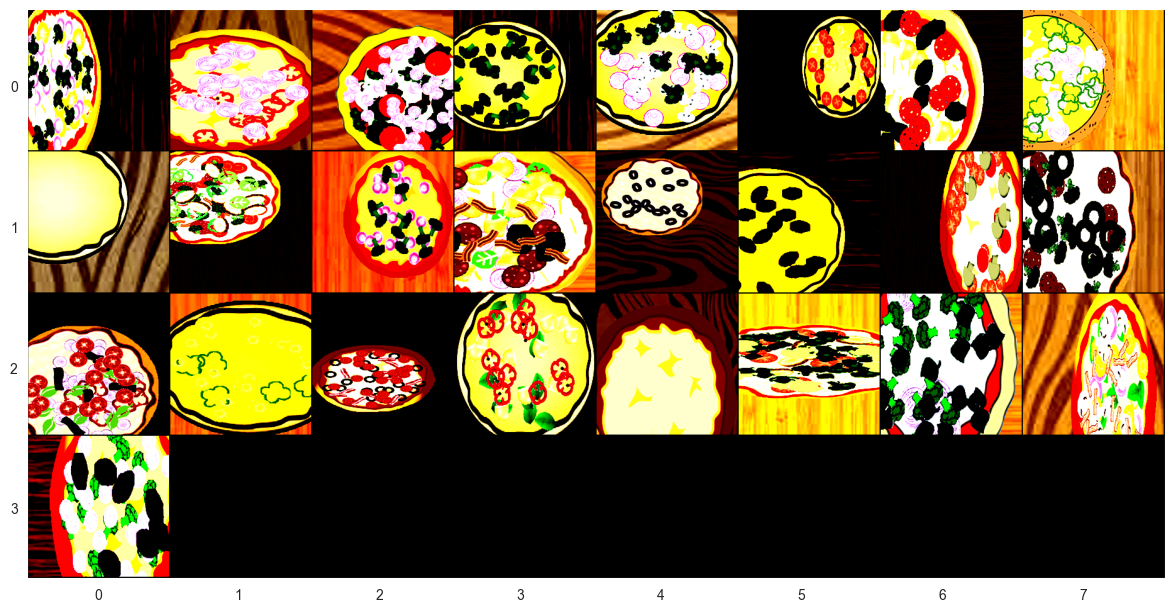

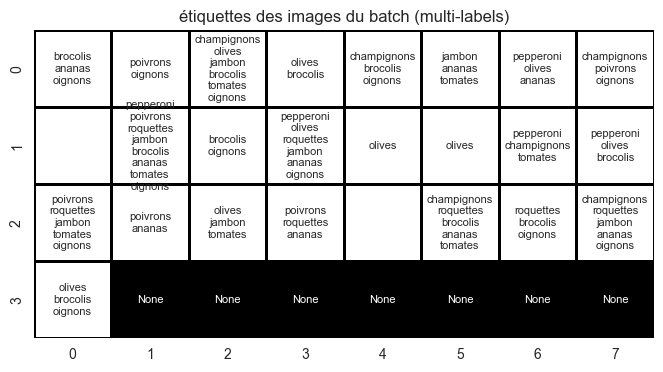

TAILLE DU BAIN : 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_size = 80 et dimension d'une image = torch.Size([3, 224, 224])


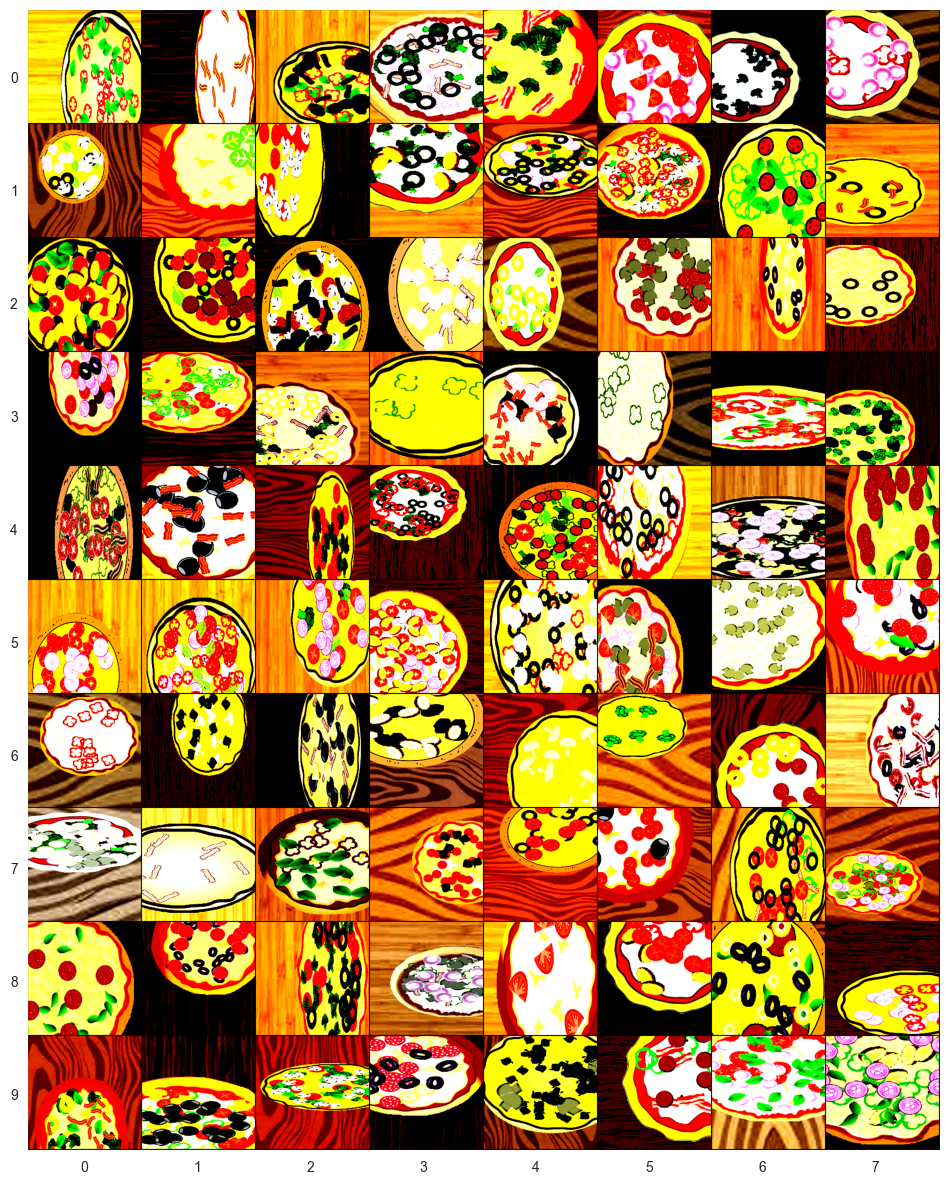

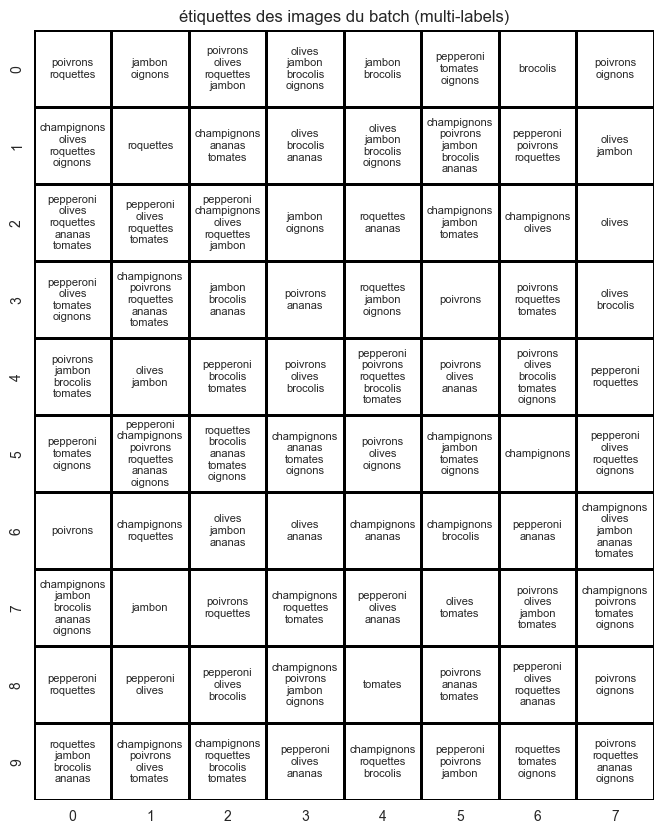

In [12]:
for batch_size in [10, 25, 80]:
    print("TAILLE DU BAIN :", batch_size)
    train = DataLoader('train', batch_size)
    train.show_one_batch()

# **Extraction de features**

*There are several possibilities to solve the problem:*

* *Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.*

* *Work on raw data and build the label predictor directly. This is typically an approach for deep learning.*

*Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.*


Dans cette partie, on va "transformer" les images dataset du dossier *train* en un simple vecteur qui représentera les features des images.
Ces nouvelles données seront stockés dans un fichier .npz (*\syntheticDataset\train\img_all_feat_resnext.npz*) et permettent comme expliquer en anglais juste au dessus de pouvoir travailler sur des modèles plus simples qui travaille pas sur des images mais sur des vecteurs.

### Compute deep features for images

*Example of how to compute deep image features. Here, we use a resnext network, but another may be as good and cheaper to compute and store.*

On utilise un modèle déjà entraîné de torchvision pour extraire les features de l'entièreté du dataset du dossier *train* ('all' = 'train' + 'val') ainsi que sur le dossier *test*.

##### *train* folder :

In [13]:
feat_data_path = os.path.join(paths.train_data, 'img_all_feat_resnext.npz')
# Checks if features already exist
if os.path.exists(feat_data_path):
    print(f"Loading image features from {feat_data_path}")
    feat = np.load(feat_data_path)
    feat = feat['img_feat']
# If not, compute them
else:
    print("Computing image features")
    from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
    resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)
    if device.type == 'cuda':
        resnext = resnext.cuda()
    model = resnext
    # Removes the last classification layer: may different for other network
    modules=list(model.children())[:-1]
    model=nn.Sequential(*modules)
    for p in model.parameters():
        p.requires_grad = False
    # If you need to put the last layer back
    #num_ftrs = resnext.fc.in_features
    #resnext.fc = nn.Linear(num_ftrs, 9)
    # Uses a dataloader with no data augmentation :
    all200 = DataLoader('all', 200)
    feat = []
    for i, data in enumerate(tqdm(all200.dataloader)):   ## on itere sur les données
        img, targets = data
        #print(targets)
        if device.type == 'cuda':
            img, targets = img.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = model(img) # extraction des features par le modèle resnet
        if device.type == 'cuda':
            feat.append(outputs.cpu().numpy().squeeze())
        else:
            feat.append(outputs.numpy().squeeze())
    feat = np.array(np.concatenate(feat))
    print("Storing image features in {}".format(feat_data_path))
    np.savez_compressed(feat_data_path, img_feat=feat)
print(feat.shape)



Loading image features from syntheticDataset/train\img_all_feat_resnext.npz
(4971, 2048)


##### *test* folder :

In [14]:
feat_test_data_path = os.path.join(paths.train_data, 'img_test_feat_resnext.npz')
# Checks if features already exist
if os.path.exists(feat_test_data_path):
    print(f"Loading image features from {feat_test_data_path}")
    feat_test = np.load(feat_test_data_path)
    feat_test = feat_test['img_feat']
# If not, compute them
else:
    print("Computing image features")
    from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
    resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)
    if device.type == 'cuda':
        resnext = resnext.cuda()
    model = resnext
    # Removes the last classification layer: may different for other network
    modules=list(model.children())[:-1]
    model=nn.Sequential(*modules)
    for p in model.parameters():
        p.requires_grad = False
    # If you need to put the last layer back
    #num_ftrs = resnext.fc.in_features
    #resnext.fc = nn.Linear(num_ftrs, 9)
    # Uses a dataloader with no data augmentation :
    test200 = DataLoader('test', 200)
    feat_test = []
    for i, data in enumerate(tqdm(test200.dataloader)):   ## on itere sur les données
        img, targets = data
        #print(targets)
        if device.type == 'cuda':
            img, targets = img.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = model(img) # extraction des features par le modèle resnet
        if device.type == 'cuda':
            feat_test.append(outputs.cpu().numpy().squeeze())
        else:
            feat_test.append(outputs.numpy().squeeze())
    feat_test = np.array(np.concatenate(feat))
    print("Storing image features in {}".format(feat_test_data_path))
    np.savez_compressed(feat_test_data_path, img_feat=feat_test)
print(feat_test.shape)

Loading image features from syntheticDataset/train\img_test_feat_resnext.npz
(497, 2048)


### Specific Data Management

On doit maintenant séparer les data en deux set : training set et validation set

In [15]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat, y_all, test_size=0.2, random_state=123)

print(f"Plutôt que de travailler sur {train25.img_data.shape[0]} données de taille {train25.img_data.shape[1:]}")
print(f"l'extraction de features permet de travailler sur {feat_train.shape[0]} données de taille {feat_train.shape[1:]}")

# Chexks if labels are the same as the image split
print(np.all(y_val == yfeat_val)) # on a pris random_state=123 donc on a extrait le validation set dans le même ordre


Plutôt que de travailler sur 3976 données de taille (224, 224, 3)
l'extraction de features permet de travailler sur 3976 données de taille (2048,)
True


### Specific DataLoader Class

Comme ici on ne travaille pas avec des images mais des vecteurs de features, on ne peut pas utiliser le même DataLoader, il faut ainsi créer une autre objet pytorch mais plus simple car on n'a pas d'image, et un DataLoader spécifique :

- on a besoin d'écrire un objet pytorch (torch.utils.data.Dataset) pour :
>1) être compatible avec d'autres objets pytorch (les torch.utils.data.DataLoader)
>2) parcourir un set du dataset avec une boucle for
- et une classe FeaturesDataLoader qui fonctionne comme notre DataLoader mais sans toutes les options d'affichage


In [16]:
# hypothèse : comme les features sont extraites sur des données (la variable all200 = DataLoader(...)) normalisée 
# par la classe notre DataLoader(DataLoader._create_normalization_transforms()), on supposera que les features
# extraites de ces données n'ont pas besoin d'être normalisé

class myFeaturesDataset(torch.utils.data.Dataset):
    """Extracted features from Pizza dataset"""
    def __init__(self, x_feat, y_feat):
        self.x_feat = x_feat
        self.y_feat = y_feat
    def __getitem__(self, idx):
        features = self.x_feat[idx]
        labels = self.y_feat[idx]
        return features, labels
    def __len__(self):
        return int(len(self.x_feat))

class FeaturesDataLoader:
    def __init__(self, which_set, batch_size):
        self.which_set = which_set
        self.batch_size = batch_size
        self.kwargs = {'num_workers': 0, 'pin_memory': True} if torch.cuda.is_available() else {}
        self._which_set_of_dataset()
        self._create_dataloader()
        self.classes = ('pepperoni', 'champignons', 'poivrons', 'olives', 'roquettes',
                        'jambon', 'brocolis', 'ananas', 'tomates', 'oignons')
    def _which_set_of_dataset(self):
        if self.which_set == 'train':
            self.x_feat = feat_train
            self.y_feat = yfeat_train
            self.do_shuffle = True
        elif self.which_set == 'val':
            self.x_feat = feat_val
            self.y_feat = yfeat_val
            self.do_shuffle = False
        elif self.which_set == 'test':
            self.x_feat = feat_test
            self.y_feat = y_test
            self.do_shuffle = False
    def _create_dataloader(self):
        self.raw_set = myFeaturesDataset(self.x_feat, self.y_feat)
        self.dataloader = torch.utils.data.DataLoader(self.raw_set, batch_size=self.batch_size,
                                                      shuffle=self.do_shuffle, **self.kwargs)
    def get_one_batch(self):
        dataiter = iter(self.dataloader)
        features, labels = next(dataiter)
        return features, labels

# **TRAINING SUPER CLASS = generic function for training**

Cette classe lance directement l’entraînement d'un modèle sur un dataset de training, sur un nombre donnée d'epochs, et avec un critère et un optimizer au choix.

Elle affichera la Loss toutes les 900 data parcourues (par exemple si on s'entraîne sur 3976 data, la Loss est affiché 4 fois par époques dans ce cas). Paramètre modifiable.

Elle enregistre ensuite les paramètres dans un fichier 'run_name.pth' ainsi que l'image avec l'évolution de la précision et de la loss pendant l’entraînement 'run_name.png', précision évaluée sur un dataset de validation (elle a donc besoin de deux DataLoader, un 'train' et un 'val').

Le choix d'en faire une classe est d'améliorer la lisibilité de l'écriture du code, plutôt que d'avoir une énorme fonction ; et aussi pour pouvoir garder les valeurs d'un entraînement en mémoire dans des objets instanciés pour chaque training. \
*Exemple :* \
*training1 = TrainEtPrecision(..., net1, ........., run1) permet d'avoir ainsi en mémoire la loss d'un training avec l'attribut training.LOSS*

Une fois l'entraînement finis, la classe va tracer l'évolution de la Loss (précisions aussi) avec les epochs et stocker en .png dans le dossier 'figures' créé au tout début, ainsi que les paramètres du modèle en .pth dans le dossier 'models' créé au tout début également.

On peut aussi visualiser sur 1 batch, les labels que le modèle entraîné obtient, en comparaison avec la ground truth de se batch. Les visualisations de ce 1 batch sont enregistrées dans le dossier 'figures'.

Les suivantes utilisation de la classe clarifieront sûrement sont fonctionnement. \
Service client de la super classe TrainEtPrecision : 0670762598

In [17]:
class TrainEtPrecision:
    
    def __init__(self,
                train_dataloader,
                val_dataloader,
                net,
                criterion,
                optimizer,
                multi_metric,
                n_epochs,
                run_name,
                add_sigmoid=False):
        self.train_dataloader = train_dataloader  # instance de la classe DataLoader 
        self.val_dataloader = val_dataloader      # instance de la classe DataLoader
        self.net = net                   # instance de la classe du modèle du reseau
        self.criterion = criterion       # critère d'optimisation
        self.optimizer = optimizer       # algo d'optimisation
        self.multi_metric = multi_metric # métrique de performance/précision multi-label
        self.n_epochs = n_epochs         # nb d'epochs pour l’entraînement
        self.run_name = run_name         # nom de la figure et du modèle pour enregistrer les résultats :
                                               # l'image de la précision en .png full HD
                                               # les paramètres du réseau final en .pth
        self.multi_metric_name = str(locals()["multi_metric"])[1:].split('at')[0].strip()
        self.add_sigmoid = add_sigmoid
        # ce dernier paramètre permet de passer des reels aux probabilités :
        # label > 0 => proba > 50% 
        # label < 0 => proba < 50%
        # chaque réseau doit finir par une couche sigmoid, si il n'en a pas ou qu'on ne peut pas en ajouté facilement (voir plus loin : Effnet),
        # on met ce paramètre sur True (intervient seulement dans le calcul des précisions, n’empêche en rien l’entraînement)
                                                 
        # variables à plotter :
        self.LOSS = []
        self.accuracy_val = []
        self.accuracy_train = []
        
        # ENTRAÎNEMENT :
        for epoch in range(1, self.n_epochs+1):  # loop over the dataset multiple times
            print(f"EPOCH #{epoch}")
            # OPTIMISATION SUR UNE EPOCH, AFFICHAGE DE LA LOSS PENDANT L'EPOCH TOUT LES 900 DATA
            self._opti_sur_une_epoch(epoch, 900)
            # CALCUL DE LA PRECISION DE TRAIN SUR UNE EPOCH :
            self._precision_train_sur_une_epoch(epoch)
            # CALCUL DE LA PRECISION DE VALIDATION SUR UNE EPOCH :
            self._precision_val_sur_une_epoch(epoch)
        print('Finished Training')
        # plot et savefig :
        self._plot_accuracy()
        # save model :
        self._save_model()
          
    def _opti_sur_une_epoch(self, epoch, n_affichage):
        running_loss = 0.0
        data_count = 0
        total_loss = 0.0
        for i, (batch) in enumerate(self.train_dataloader.dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.float()
            # zero the parameter gradients
            self.optimizer.zero_grad()
            # forward + backward + optimize
            outputs = self.net(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
            data_count += self.train_dataloader.batch_size
            if data_count >= n_affichage: # print loss every n_affichage data
                print(f'[{epoch}, {i * self.train_dataloader.batch_size}] loss: {running_loss / n_affichage * self.train_dataloader.batch_size:.3f}')
                data_count = 0
                running_loss = 0.0
        self.LOSS.append(total_loss / len(self.train_dataloader.raw_set) * self.train_dataloader.batch_size) # loss sur une epoch
        
    def _precision_train_sur_une_epoch(self, epoch):
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for batch in self.train_dataloader.dataloader:
                inputs, labels = batch
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = self.net(inputs) # network with parameters of current epoch
                if self.add_sigmoid: outputs = F.sigmoid(outputs)
                labels, outputs = labels.cpu().numpy(), outputs.cpu().numpy()
                all_predictions.append(outputs)
                all_labels.append(labels)
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        precision = self.multi_metric(all_labels, all_predictions.round(), average='samples')
        print(f'Accuracy score ({self.multi_metric_name}) of the network on the {len(self.train_dataloader.raw_set)} training data: {100*precision} %')
        self.accuracy_train.append(100*precision)
    
    def _precision_val_sur_une_epoch(self, epoch):
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for batch in self.val_dataloader.dataloader:
                inputs, labels = batch
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = self.net(inputs) # network with parameters of current epoch
                if self.add_sigmoid: outputs = F.sigmoid(outputs)
                labels, outputs = labels.cpu().numpy(), outputs.cpu().numpy()
                all_predictions.append(outputs)
                all_labels.append(labels)
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        precision = self.multi_metric(all_labels, all_predictions.round(), average='samples')
        print(f'Accuracy score ({self.multi_metric_name}) of the network on the {len(self.val_dataloader.raw_set)} validation data: {100*precision} %')
        self.accuracy_val.append(100*precision)
        
    def _plot_accuracy(self):
        epochs = list(range(1, self.n_epochs+1))
        plt.figure(figsize=(10, 10))
        plt.suptitle(f"{self.run_name}, batch_size={self.train_dataloader.batch_size}, metric = {self.multi_metric_name}")
        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.accuracy_val, ".--", label="Validation accuracy")
        final_acc = self.accuracy_val[-1]
        title = "Validation accuracy: {:.4f}".format(final_acc)
        plt.ylabel("Accuracy/score (%)")
        plt.plot(epochs, self.accuracy_train, "o-", label="Training accuracy")
        final_train_acc = self.accuracy_train[-1]
        title += ", Training accuracy: {:.4f}".format(final_train_acc)
        plt.title(title)
        plt.xlabel("epochs")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(epochs, self.LOSS, 'o-k')
        plt.ylabel("Loss")
        plt.xlabel("epochs")
        plt.title("Loss")
        plt.tight_layout()
        name = os.path.join(paths.figures_path, f"{self.run_name}_bs_{self.train_dataloader.batch_size}_epochs_{self.n_epochs}.png")
        plt.savefig(name, dpi=300, bbox_inches='tight')
        
    def _save_model(self):
        torch.save(self.net.state_dict(), 
                   os.path.join(paths.models_path, f"{self.run_name}_bs_{self.train_dataloader.batch_size}_epochs_{self.n_epochs}.pth")) 
        
    def show_estimation_of_one_batch(self):
        inputs, labels = self.val_dataloader.get_one_batch()
        inputs = inputs.cuda()
        outputs = self.net(inputs)
        if self.add_sigmoid: outputs = F.sigmoid(outputs)
        outputs = outputs.round().cpu()
        NX = int(np.sqrt(self.val_dataloader.batch_size))
        NY = int(self.val_dataloader.batch_size/NX) + 1
        # it's plotting time :
        self._show_labels_as_grid(labels, NX, NY, "GROUND_TRUTH")
        self._show_labels_as_grid(outputs, NX, NY, "TRAINED_NETWORK_PREDICTION")
        
    def _show_labels_as_grid(self, labels, NX, NY, title):
        class_names = np.array(self.val_dataloader.classes)
        labels_name = [class_names[label==1] for label in labels]
        labels_table = np.full((NY, NX), None)
        try:
            for ny in range(NY):
                for nx in range(NX):
                    labels_table[ny, nx] = '\n'.join(labels_name[ny*NX + nx])
        except IndexError:
            pass
        df = pd.DataFrame(labels_table)
        plt.figure(figsize=(NX, NY))
        sns.heatmap(df.isnull(), cmap='binary', cbar=False, annot=df.values, fmt='',
                    annot_kws={'size': 8}, linewidths=1, linecolor='black')
        plt.title(f'{title} étiquettes des images du batch (multi-labels)')
        name = os.path.join(paths.figures_path, f"{self.run_name}_bs_{self.train_dataloader.batch_size}_epochs_{self.n_epochs}_ONE_BATCH_{title}.png")
        plt.savefig(name, dpi=300, bbox_inches='tight')
        plt.show()
        
    def precision_du_modèle(self, test_dataloader):
        # CALCUL DU SCORE DE PRECISION DU MODÈLE FINAL (test set)
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for batch in test_dataloader.dataloader:
                inputs, labels = batch
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = self.net(inputs) # network with parameters of current epoch
                if self.add_sigmoid: outputs = F.sigmoid(outputs)
                labels, outputs = labels.cpu().numpy(), outputs.cpu().numpy()
                all_predictions.append(outputs)
                all_labels.append(labels)
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        precision = self.multi_metric(all_labels, all_predictions.round(), average='samples')
        print(f'Accuracy score ({self.multi_metric_name}) of the network on the {len(test_dataloader.raw_set)} test data: {100*precision} %')
        

L'argument *run_name* est le nom utilisé pour reconnaître une run (= 1 entraînement) parmi les fichiers enregistrés dans 'figures'/'models'.

Les noms complets des fichiers préciseront la taille du batch ainsi que le nombre d'époques : \
format : **run_name_bs_25_epochs_20.png* (avec par exemple 25 en batch_size et 20 époques au total)

Ce qu'il reste à spécifier dans le string *run_name* est le modèle utilisé et pourquoi pas le critère/algo d'opti utilisé etc.

# **Modèles simples**

## **Learning multi-label from pre-computed features**

### Création d'un modèle :

In [19]:
class SimpleFeaturesNet(nn.Module):
    def __init__(self, input_size=2048, output_size=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


### Entraînements :

On va entrainer le modèle avec un critère multilabel (BCELoss) et l'algo de descente de gradient à pas adaptatif Adam, pour un batch_size de 25, pendant 10 epochs.
On va faire deux runs pour visualiser les différences entre les deux métriques f1-score et precision-score de sklearn.

##### run1 : *f1_score*

EPOCH #1
[1, 875] loss: 0.568
[1, 1775] loss: 0.461
[1, 2675] loss: 0.408
[1, 3575] loss: 0.394
Accuracy score (function f1_score) of the network on the 3976 training data: 68.6954457905162 %
Accuracy score (function f1_score) of the network on the 995 validation data: 63.27108290927386 %
EPOCH #2
[2, 875] loss: 0.339
[2, 1775] loss: 0.317
[2, 2675] loss: 0.305
[2, 3575] loss: 0.304
Accuracy score (function f1_score) of the network on the 3976 training data: 75.86184006581391 %
Accuracy score (function f1_score) of the network on the 995 validation data: 66.47367428774464 %
EPOCH #3
[3, 875] loss: 0.258
[3, 1775] loss: 0.258
[3, 2675] loss: 0.255
[3, 3575] loss: 0.268
Accuracy score (function f1_score) of the network on the 3976 training data: 83.34084342887161 %
Accuracy score (function f1_score) of the network on the 995 validation data: 70.19837225867377 %
EPOCH #4
[4, 875] loss: 0.220
[4, 1775] loss: 0.214
[4, 2675] loss: 0.215
[4, 3575] loss: 0.226
Accuracy score (function f1_scor

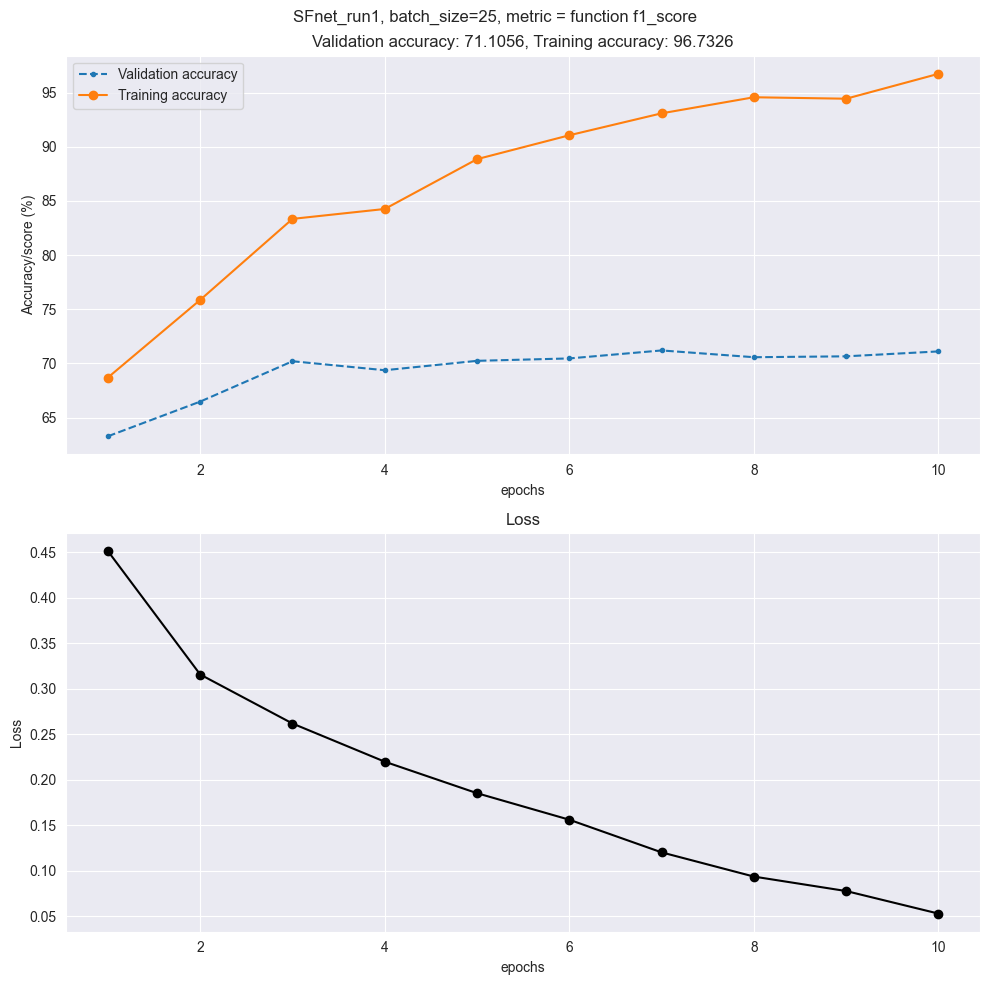

In [20]:
SFnet = SimpleFeaturesNet()
SFnet = SFnet.cuda()

# multilabel criterion :
criterion = nn.BCELoss()
# algo d'opti :
optimizer = torch.optim.Adam(SFnet.parameters(), lr=0.001)
# batch_size = 25
features_train25 = FeaturesDataLoader('train', 25)
features_val25 = FeaturesDataLoader('val', 25)

SFnet_run1 = TrainEtPrecision(
    features_train25,
    features_val25,
    SFnet, 
    criterion, 
    optimizer,
    f1_score,
    10, 
    "SFnet_run1"
    )

##### run2 : *precision_score*

EPOCH #1
[1, 875] loss: 0.570
[1, 1775] loss: 0.458
[1, 2675] loss: 0.410
[1, 3575] loss: 0.399
Accuracy score (function precision_score) of the network on the 3976 training data: 79.92128365430679 %
Accuracy score (function precision_score) of the network on the 995 validation data: 73.48217276860493 %
EPOCH #2
[2, 875] loss: 0.339
[2, 1775] loss: 0.325
[2, 2675] loss: 0.316
[2, 3575] loss: 0.308
Accuracy score (function precision_score) of the network on the 3976 training data: 86.95068226821246 %
Accuracy score (function precision_score) of the network on the 995 validation data: 78.5264417324719 %
EPOCH #3
[3, 875] loss: 0.262
[3, 1775] loss: 0.262
[3, 2675] loss: 0.277
[3, 3575] loss: 0.253
Accuracy score (function precision_score) of the network on the 3976 training data: 90.7123395132701 %
Accuracy score (function precision_score) of the network on the 995 validation data: 79.82747068676717 %
EPOCH #4
[4, 875] loss: 0.211
[4, 1775] loss: 0.218
[4, 2675] loss: 0.216
[4, 3575] los

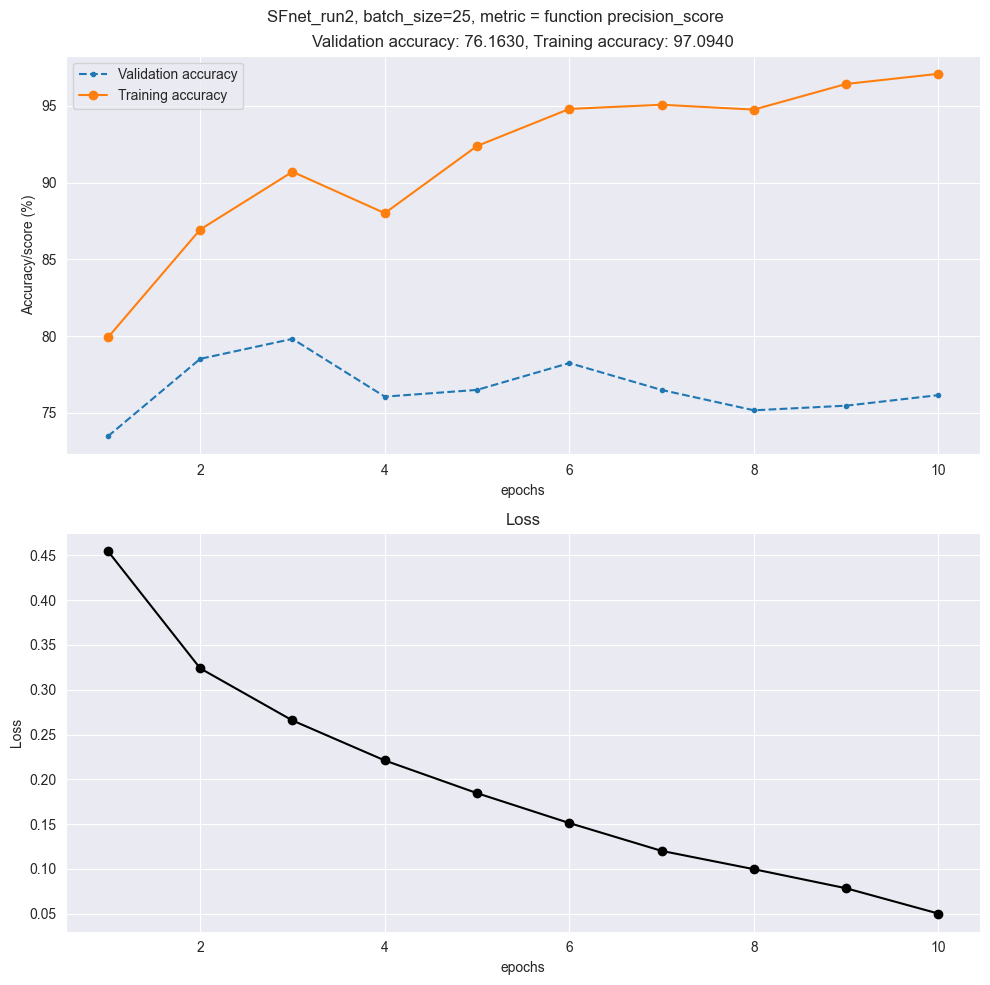

In [20]:
SFnet = SimpleFeaturesNet()
SFnet = SFnet.cuda()

# multilabel criterion :
criterion = nn.BCELoss()
# algo d'opti :
optimizer = torch.optim.Adam(SFnet.parameters(), lr=0.001)
# batch_size = 25
features_train25 = FeaturesDataLoader('train', 25)
features_val25 = FeaturesDataLoader('val', 25)

SFnet_run2 = TrainEtPrecision(
    features_train25,
    features_val25,
    SFnet, 
    criterion, 
    optimizer,
    precision_score,
    10, 
    "SFnet_run2"
    )

### Visualisation du résultat sur 1 batch :

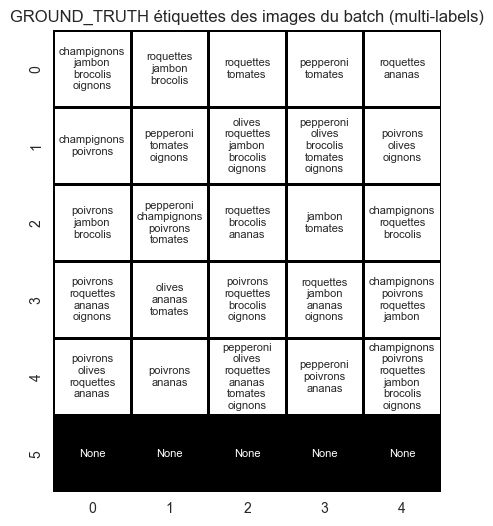

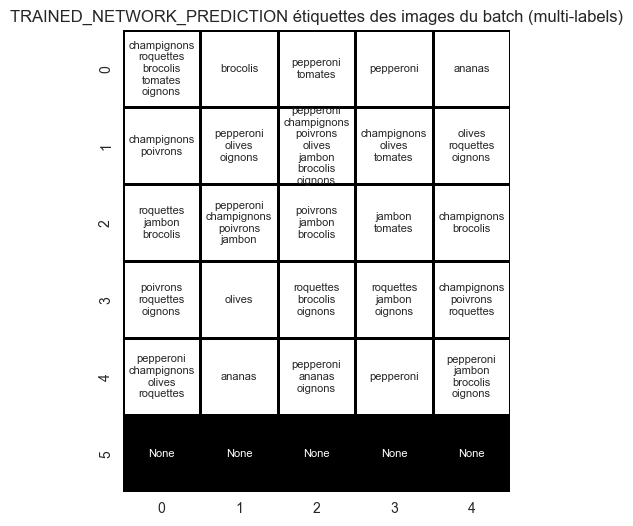

In [21]:
SFnet_run1.show_estimation_of_one_batch()

## **Learning multi-label from raw images**

### Création d'un modèle

adaptation de https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
# Network requires 128x128 input images (ici on resize)
    def __init__(self, 
                 in_channels = 3, 
                 out_channels = 10):
        # in_channels = 3, pour rvb
        # out_channels = 10, c'est le nb de classes
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128

        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32  

        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8

        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2

        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, out_channels)) #output 11   
    def forward(self, x):
        ## Resize :
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        ## stage 1 :
        x = self.conv1(x)
        x = self.res1(x) #+ x
        ## stage 2 :
        x = self.conv2(x)
        x = self.res2(x) #+ x
        ## stage 3 :
        x = self.conv3(x)
        x = self.res3(x) #+ x
        ## stage 4 :
        x = self.conv4(x)
        x = self.res4(x) #+ x
        ## classification stage :
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x
    def size_debug(self, x):
          forward_source = inspect.getsource(self.forward)
          forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
          local_vars = locals()
          print("in :")
          print(x.shape)
          for line in forward_lines:
              if line.strip():
                  if line.strip()[0] != '#':
                      exec(line.strip(), globals(), local_vars)
                      x = local_vars['x']
                      print(x.shape)
                  elif line.strip()[0:2] == '##':
                      print(line.strip())
          print("out.")
    # cette méthode ici sert à voir la taille d'un objet qui traverse le réseau après chaque couche


La méthode .size_debug(images.cuda()) :

Elle permet de lancer une entrée à travers le réseau et d'afficher couche après couché la forme des données, jusqu'a la sortie du réseau. On l'a utilisé pour debuger nos modèles, pour vérifier les incomptabilités de shape ou de dimension. 

Elle est écrite de manière à s'adapter aux modifications éventuelles des classes des modèles des réseau de neurones : on a pas besoin de la modifier si jamais on modifie le modèle, elle va lire la methode .forward() et l'executée ligne par ligne sauf si il y a un commentaire ou va print le commentaire si il commence par '##'.


In [23]:
Rnet = ResNet()
Rnet = Rnet.cuda()

images, labels = train25.get_one_batch()
Rnet.size_debug(images.cuda())

in :
torch.Size([25, 3, 224, 224])
## Resize :
torch.Size([25, 3, 128, 128])
## stage 1 :
torch.Size([25, 64, 128, 128])
torch.Size([25, 64, 128, 128])
## stage 2 :
torch.Size([25, 128, 32, 32])
torch.Size([25, 128, 32, 32])
## stage 3 :
torch.Size([25, 512, 8, 8])
torch.Size([25, 512, 8, 8])
## stage 4 :
torch.Size([25, 1024, 2, 2])
torch.Size([25, 1024, 2, 2])
## classification stage :
torch.Size([25, 10])
torch.Size([25, 10])
out.


### Entraînements :

On va entrainer le modèle avec un critère multilabel (BCELoss) et l'algo de descente de gradient à pas adaptatif Adam, pour un batch_size de 25, pendant 10 epochs.
On va faire deux runs pour visualiser les différences entre les deux métriques f1-score et precision-score de sklearn.

##### run1 : *f1_score*

EPOCH #1
[1, 875] loss: 0.612
[1, 1775] loss: 0.569
[1, 2675] loss: 0.551
[1, 3575] loss: 0.550
Accuracy score (function f1_score) of the network on the 3976 training data: 17.254179840950464 %
Accuracy score (function f1_score) of the network on the 995 validation data: 16.5266012602696 %
EPOCH #2
[2, 875] loss: 0.550
[2, 1775] loss: 0.540
[2, 2675] loss: 0.532
[2, 3575] loss: 0.523
Accuracy score (function f1_score) of the network on the 3976 training data: 24.005601066717766 %
Accuracy score (function f1_score) of the network on the 995 validation data: 22.09053202520539 %
EPOCH #3
[3, 875] loss: 0.521
[3, 1775] loss: 0.511
[3, 2675] loss: 0.518
[3, 3575] loss: 0.516
Accuracy score (function f1_score) of the network on the 3976 training data: 29.802006483344513 %
Accuracy score (function f1_score) of the network on the 995 validation data: 28.06229560500917 %
EPOCH #4
[4, 875] loss: 0.508
[4, 1775] loss: 0.498
[4, 2675] loss: 0.497
[4, 3575] loss: 0.495
Accuracy score (function f1_s

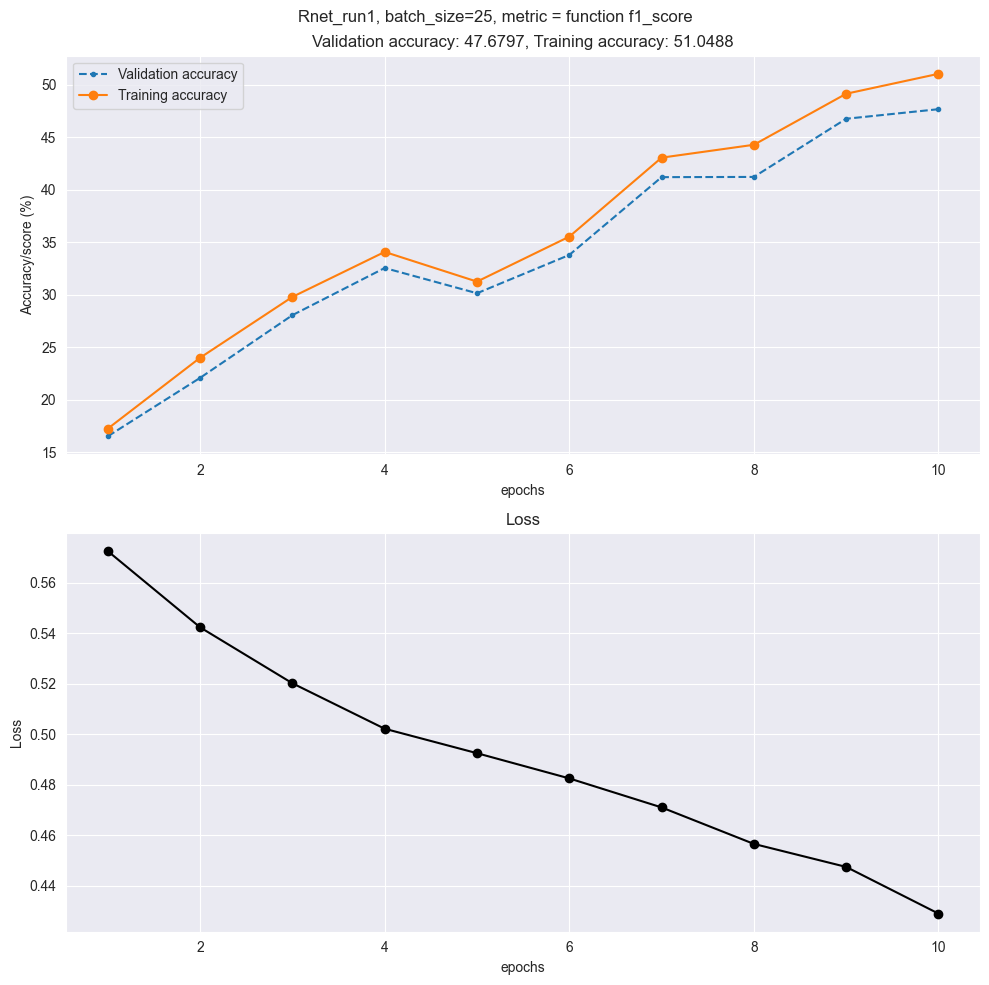

In [24]:
Rnet = ResNet()
Rnet = Rnet.cuda()

# multilabel criterion :
criterion = nn.BCELoss()
# algo d'opti :
optimizer = torch.optim.Adam(Rnet.parameters(), lr=0.001)
# batch_size = 25

Rnet_run1 = TrainEtPrecision(
    train25,
    val25,
    Rnet, 
    criterion, 
    optimizer,
    f1_score,
    10, 
    "Rnet_run1"
    )

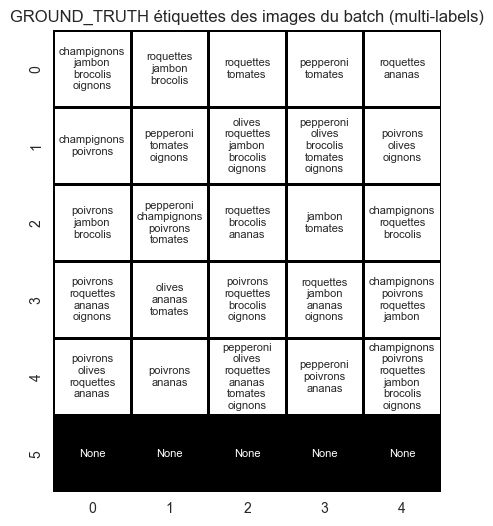

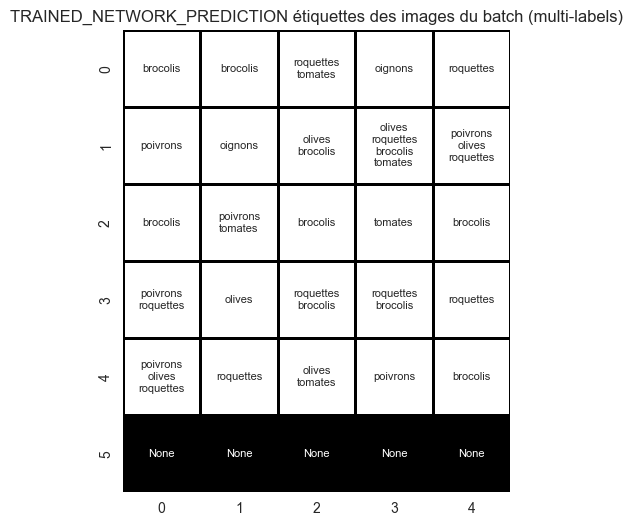

In [25]:
Rnet_run1.show_estimation_of_one_batch()

##### run2 : *precision_score*

EPOCH #1
[1, 875] loss: 0.637
[1, 1775] loss: 0.584
[1, 2675] loss: 0.570
[1, 3575] loss: 0.551
Accuracy score (function precision_score) of the network on the 3976 training data: 27.213279678068407 %
Accuracy score (function precision_score) of the network on the 995 validation data: 28.34170854271357 %
EPOCH #2
[2, 875] loss: 0.544
[2, 1775] loss: 0.542
[2, 2675] loss: 0.533
[2, 3575] loss: 0.528
Accuracy score (function precision_score) of the network on the 3976 training data: 53.609154929577464 %
Accuracy score (function precision_score) of the network on the 995 validation data: 53.04857621440535 %
EPOCH #3
[3, 875] loss: 0.516
[3, 1775] loss: 0.518
[3, 2675] loss: 0.498
[3, 3575] loss: 0.493
Accuracy score (function precision_score) of the network on the 3976 training data: 50.18318242790074 %
Accuracy score (function precision_score) of the network on the 995 validation data: 48.06197654941373 %
EPOCH #4
[4, 875] loss: 0.495
[4, 1775] loss: 0.475
[4, 2675] loss: 0.460
[4, 3575]

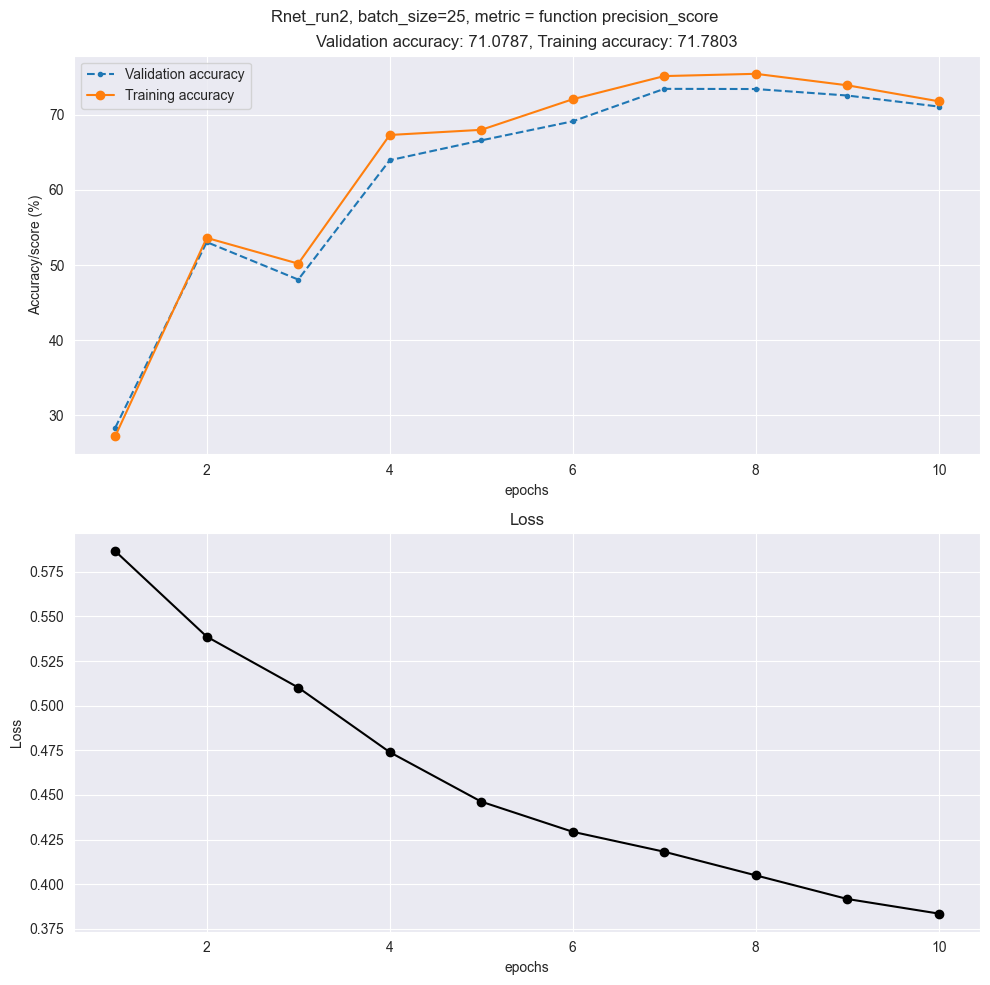

In [26]:
Rnet = ResNet()
Rnet = Rnet.cuda()

# multilabel criterion :
criterion = nn.BCELoss()
# algo d'opti :
optimizer = torch.optim.SGD(Rnet.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(Rnet.parameters(), lr=0.001)
# batch_size = 25
# dataloader déjà existants

Rnet_run2 = TrainEtPrecision(
    train25,
    val25,
    Rnet, 
    criterion, 
    optimizer,
    precision_score,
    10, 
    "Rnet_run2"
    )

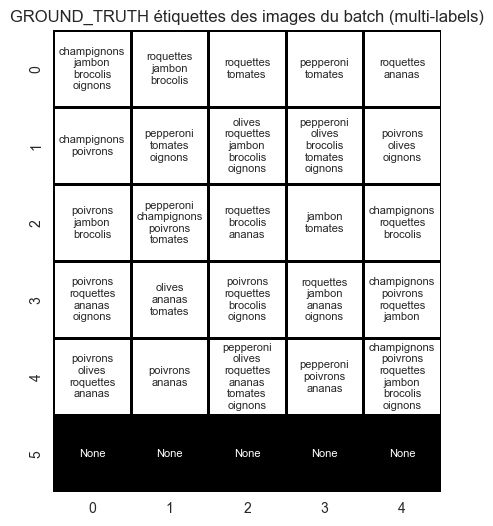

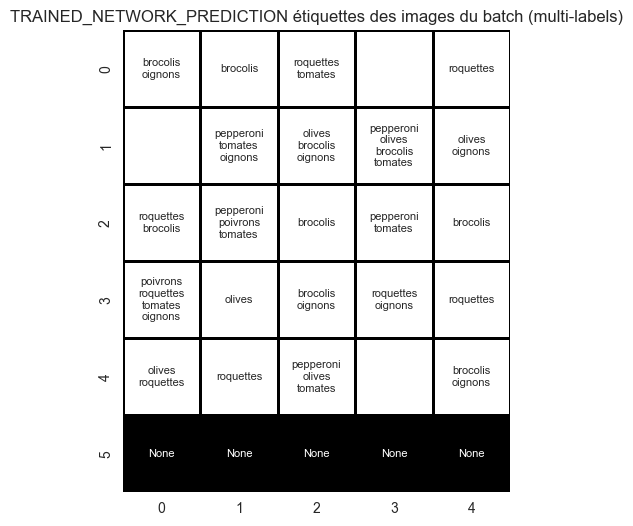

In [27]:
Rnet_run2.show_estimation_of_one_batch()

## Remarques :

Traiter les features et non les images permet un gain de temps énorme :
* le temps de computation est beaucoup plus court
* la convergence est beaucoup plus rapide

On remarque cependant que l'écart entre la précision de train et de validation se creuse beaucoup plus vite sur le modèle qui traite les features plutôt que sur le modèle qui traite les images. Ce dernier bien que long à entraîner souffre moins de l'overfitting.

En visualiser les prédictions du modèle sur les images on est assez dessus car il nécessiterait sûrement de faire plus d'itérations, ou d'avoir un modèle plus adapter et plus complexe.

*temps de computation en bonnes conditions :*
| Modèle  | SimpleFeaturesNet | ResNet |
|---------|-----|------------|
| f1-score | 18.2s | 16min27s |
| precision-score | 17.8s  | 13min1s |

Autre remarque : le temps de calcul de la precision est plus court pour le precision-score que pour le f1-score\
Le temps de computation affiché ç titre indicatif au dessus n'est représentatif qu'une d'une mesure, pour illustrer, mais le temps varie énormement une fois sur deux (parfois ça peut prendre + de 30min...), en fonction de la matière sur lequel est le pc (le bois refroidit mieux le GPU..) et si l'ordinateur est en train de charger ou non, etc...

# **Modèle plus complexe**

### Another more complex network

From torchvision.\
Il s'agit d'un modèle pré-entraîné, on se limitera donc à 3 itérations.

In [22]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights # "efficientNet"
Effnet = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = Effnet.classifier[1].in_features
Effnet.classifier[1]= nn.Linear(num_ftrs, 10)

### Entraînement :

L'entraînement n'est pas nécessaire c'est juste pour que le modèle s'adapte à nos données, mais on voit très rapidement de l'overfitting ici si on itère trop.

##### run1 : *f1_score*

EPOCH #1
[1, 875] loss: 0.419
[1, 1775] loss: 0.234
[1, 2675] loss: 0.160
[1, 3575] loss: 0.143
Accuracy score (function f1_score) of the network on the 3976 training data: 92.5976227271499 %
Accuracy score (function f1_score) of the network on the 995 validation data: 91.40652033616858 %
EPOCH #2
[2, 875] loss: 0.110
[2, 1775] loss: 0.083
[2, 2675] loss: 0.078
[2, 3575] loss: 0.070
Accuracy score (function f1_score) of the network on the 3976 training data: 94.60314305636237 %
Accuracy score (function f1_score) of the network on the 995 validation data: 93.36360847416125 %
EPOCH #3
[3, 875] loss: 0.071
[3, 1775] loss: 0.054
[3, 2675] loss: 0.058
[3, 3575] loss: 0.058
Accuracy score (function f1_score) of the network on the 3976 training data: 95.14708156810772 %
Accuracy score (function f1_score) of the network on the 995 validation data: 93.81862358746783 %
Finished Training


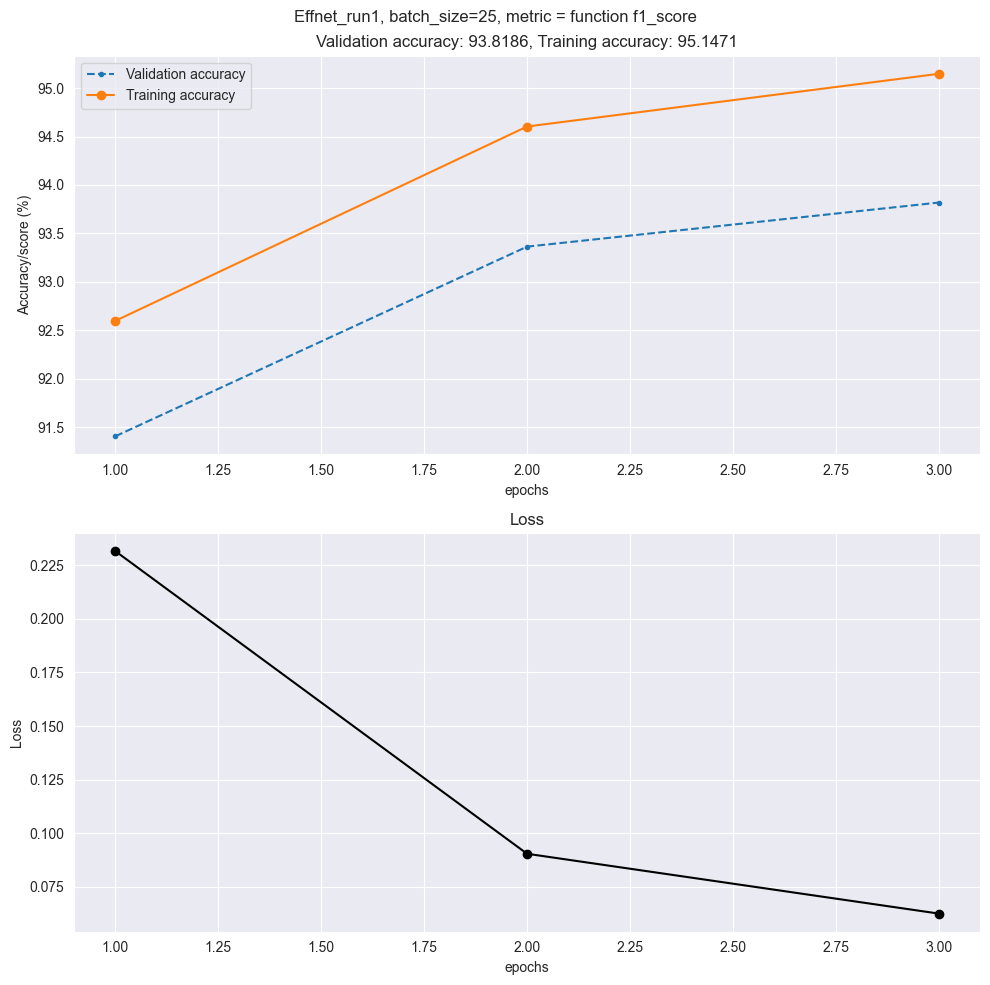

In [23]:
Effnet = Effnet.cuda()
# multilabel criterion :
criterion = nn.BCEWithLogitsLoss()
#criterion = F.binary_cross_entropy_with_logits
# algo d'opti :
optimizer = torch.optim.Adam(Effnet.parameters(), lr=0.001)
# batch_size = 25

Effnet_run1 = TrainEtPrecision(
    train25,
    val25,
    Effnet, 
    criterion, 
    optimizer,
    f1_score,
    3,
    "Effnet_run1",
    add_sigmoid = True
    )

##### run2 : *precision_score*

EPOCH #1
[1, 875] loss: 0.442
[1, 1775] loss: 0.239
[1, 2675] loss: 0.158
[1, 3575] loss: 0.125
Accuracy score (function precision_score) of the network on the 3976 training data: 93.9676750982083 %
Accuracy score (function precision_score) of the network on the 995 validation data: 93.35295525245274 %
EPOCH #2
[2, 875] loss: 0.097
[2, 1775] loss: 0.082
[2, 2675] loss: 0.085
[2, 3575] loss: 0.077
Accuracy score (function precision_score) of the network on the 3976 training data: 95.8856711698764 %
Accuracy score (function precision_score) of the network on the 995 validation data: 95.16810241684614 %
EPOCH #3
[3, 875] loss: 0.057
[3, 1775] loss: 0.059
[3, 2675] loss: 0.070
[3, 3575] loss: 0.065
Accuracy score (function precision_score) of the network on the 3976 training data: 96.05118808086614 %
Accuracy score (function precision_score) of the network on the 995 validation data: 94.91564967695622 %
Finished Training


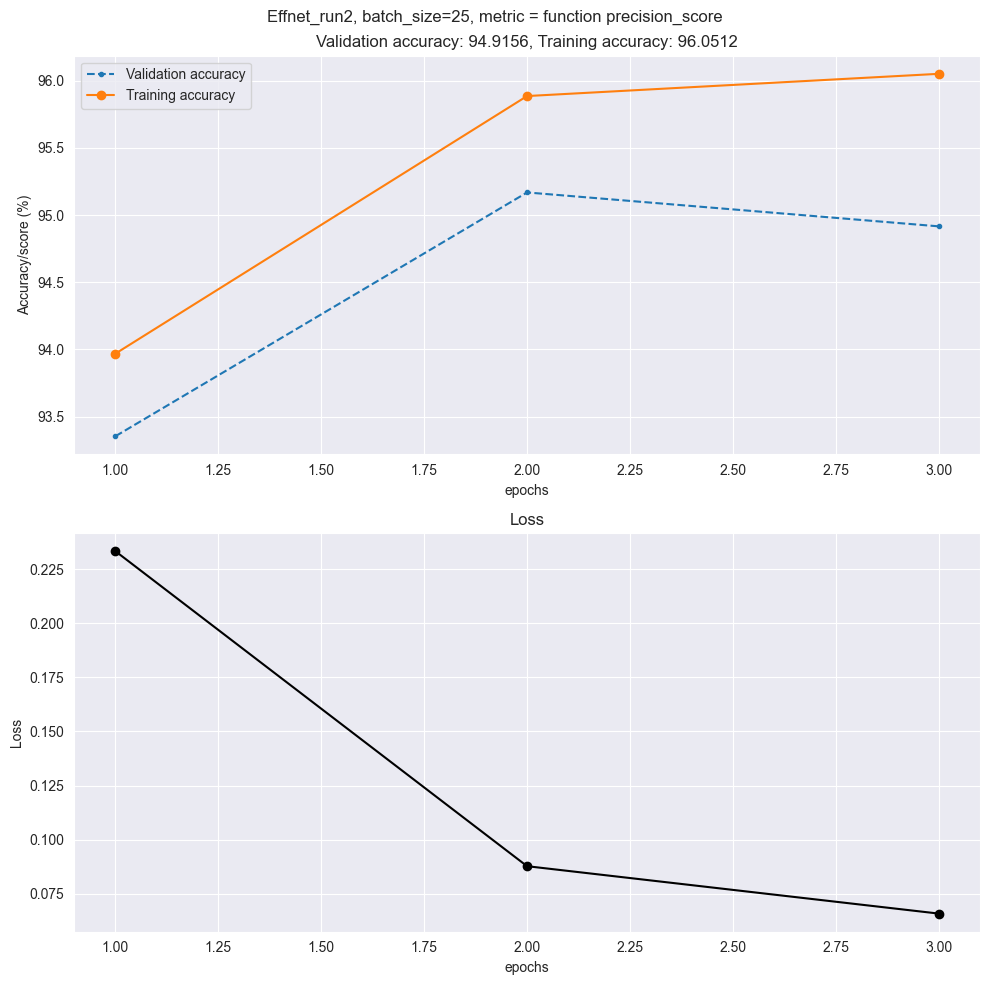

In [30]:
Effnet = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = Effnet.classifier[1].in_features
Effnet.classifier[1]= nn.Linear(num_ftrs, 10)
Effnet = Effnet.cuda()
# multilabel criterion :
criterion = nn.BCEWithLogitsLoss()
# algo d'opti :
optimizer = torch.optim.Adam(Effnet.parameters(), lr=0.001)
# batch_size = 25

Effnet_run2 = TrainEtPrecision(
    train25,
    val25,
    Effnet, 
    criterion, 
    optimizer,
    precision_score,
    3, 
    "Effnet_run2",
    add_sigmoid=True
    )

### Visualisation du résultat sur 1 batch :

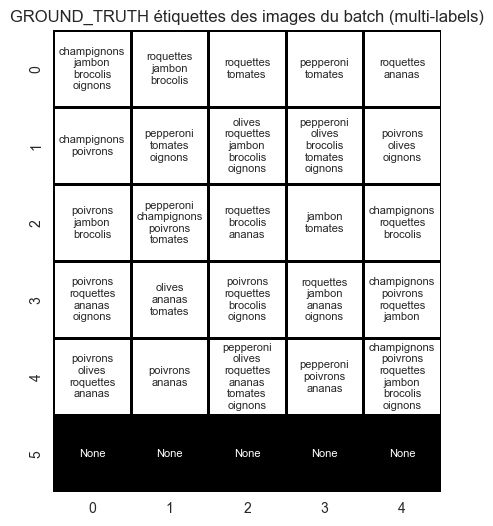

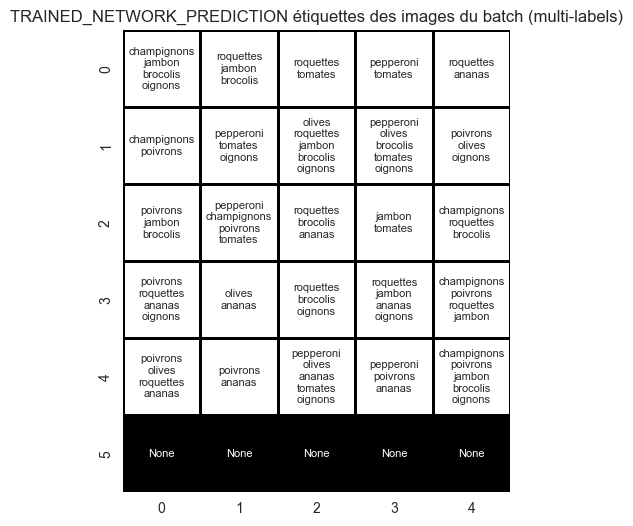

In [25]:
Effnet_run1.show_estimation_of_one_batch()
# la prédiction est impressionnante ...

## **Evaluations finales**

Cette fois, avec les modèles entraînés, on veut les évaluer sur des données non-vue : le test set.


On utilise deux métriques :
* le f1-score (run1)
* la precision-score (run2)

In [31]:
features_test25 = FeaturesDataLoader('test', 25)

print("modèle simple sur features :")
SFnet_run1.precision_du_modèle(features_test25)
SFnet_run2.precision_du_modèle(features_test25)
print("modèle simple sur images :")
Rnet_run1.precision_du_modèle(test25)
Rnet_run2.precision_du_modèle(test25)
print("modèle plus complexe sur images :")
Effnet_run1.precision_du_modèle(test25)
Effnet_run1.precision_du_modèle(test25)

modèle simple sur features :
Accuracy score (function f1_score) of the network on the 497 test data: 71.77613913026387 %
Accuracy score (function precision_score) of the network on the 497 test data: 76.70283606400305 %
modèle simple sur images :
Accuracy score (function f1_score) of the network on the 497 test data: 48.27684723056957 %
Accuracy score (function precision_score) of the network on the 497 test data: 73.16566063044935 %
modèle plus complexe sur images :
Accuracy score (function f1_score) of the network on the 497 test data: 96.05106384784455 %
Accuracy score (function f1_score) of the network on the 497 test data: 96.00871071696022 %


## **Et pour des images réelles ?**

Ici pour s'amuser on va essayer de voir les prédictions se ces réseaux sur des images non synthétique. Une image est une image de pizza et cela à du sens et l'autre n'en est pas c'est simplement pour voir quelle pizza correspondrait...

In [60]:
# 1) charger les réseaux entraînés :

Rnet = ResNet()
Rnet.load_state_dict(torch.load(os.path.join(paths.models_path, "Rnet_run1_bs_25_epochs_10.pth")))

SFnet = SimpleFeaturesNet()
SFnet.load_state_dict(torch.load(os.path.join(paths.models_path, "SFnet_run1_bs_25_epochs_10.pth")))

Effnet = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = Effnet.classifier[1].in_features
Effnet.classifier[1]= nn.Linear(num_ftrs, 10)
Effnet.load_state_dict(torch.load(os.path.join(paths.models_path, "Effnet_run1_bs_25_epochs_3.pth")))

<All keys matched successfully>

In [93]:
# 2) charger les images sur le web :

import requests
from PIL import Image
from io import BytesIO 


url1 = "https://fr.ooni.com/cdn/shop/articles/Margherita-9920.jpg?crop=center&height=800&v=1644590066&width=800"
url2 = "https://www.francetvinfo.fr/pictures/bTcyvGPo5XCmovyBA3vRyiVsuFo/1500x843/2019/04/12/portrait-officiel-macron-76c6f8-01x.jpg"

# image depuis lien url (plus facile pour partager)
response = requests.get(url1)
img1 = Image.open(BytesIO(response.content))
response = requests.get(url2)
img2 = Image.open(BytesIO(response.content))

# 3) normaliser et resize les images :
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img1 = transform(img1)
img2 = transform(img2)


# 4) extraction de leurs features :

from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)
model = resnext
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)

img1_features = model(img1.unsqueeze(0)).squeeze()
img2_features = model(img2.unsqueeze(0)).squeeze()


In [99]:
# 5) prédictions avec les réseaux précédemment charger :

img1_pred_Rnet = Rnet(img1.unsqueeze(0))

img1_pred_SFnet = SFnet(img1_features.unsqueeze(0))

img1_pred_Effnet = F.sigmoid(Effnet(img1.unsqueeze(0)))


img2_pred_Rnet = Rnet(img2.unsqueeze(0))

img2_pred_SFnet = SFnet(img2_features.unsqueeze(0))

img2_pred_Effnet = F.sigmoid(Effnet(img2.unsqueeze(0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


             Classes                 Rnet                SFnet               Effnet
           pepperoni                31.0%                12.0%                17.0%
         champignons                38.0%                20.0%                30.0%
            poivrons                49.0%                15.0%                30.0%
              olives                95.0%                 7.0%                30.0%
           roquettes                65.0%                 9.0%                40.0%
              jambon                38.0%                 7.0%                18.0%
            brocolis                32.0%                11.0%                48.0%
              ananas                36.0%                 3.0%                19.0%
             tomates                39.0%                 6.0%                22.0%
             oignons                37.0%                 3.0%                13.0%


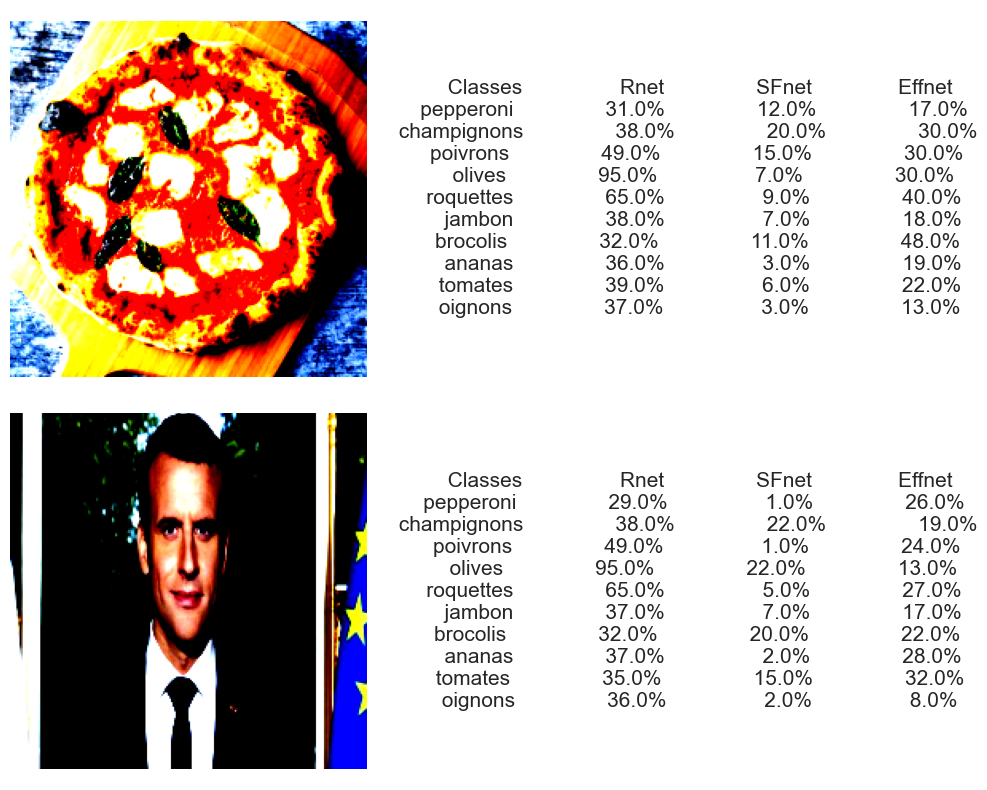

In [130]:
# 6) afficher les résultats :

def print_prediction_proba(classes, list_predic_et_nom):
    df = pd.DataFrame({'Classes': classes})
    for l in list_predic_et_nom:
        nom, preds = l[0], l[1]
        preds = (preds*100).round()
        preds = preds.squeeze().tolist()
        df[nom] = [f"{pred}%" for pred in preds]
    return df.to_string(index=False, col_space=20)

L_img1 = [("Rnet", img1_pred_Rnet),
          ("SFnet", img1_pred_SFnet),
          ("Effnet", img1_pred_Effnet)]
L_img2 = [("Rnet", img2_pred_Rnet),
          ("SFnet", img2_pred_SFnet),
          ("Effnet", img2_pred_Effnet)]
classes = train25.classes

    
txt1 = print_prediction_proba(classes, L_img1)
txt2 = print_prediction_proba(classes, L_img2)
print(txt1)

images = [img1, img2]
textes = [txt1, txt2]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()[::2]):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.grid(False)
    ax.axis('off')
for i, ax in enumerate(axes.flatten()[1::2]):
    ax.text(0.5, 0.5, textes[i], ha='center', va='center', fontsize=15)
    ax.axis('off')
plt.tight_layout()
plt.show()


On voit que les réseaux ne sont pas fait pour travailler sur des images non segmentées. De plus la normalisation assombrie beaucoup les images et fait ressortir des zones sombres interprétables comme des olives ; en dehors de cela il y a peu à interpréter. A l'exception que macron serait succulent en pizza olives roquettes.